In [15]:
data_dir = "../lhx/piper_real_cnn/data/collect_success"
image_type: str = 'pointcloud'
image_scale: float = 1.0
output_type: str = 'ee_pose' 
action_chunk: int = 50
action_stride: int = 1
batch_size: int = 8
train_split: float = 0.8
window_size: int = 1
num_workers: int = 4
data_aug: int = 1

In [16]:
import sys
sys.path.append('/home/zhouhao/work/manipulation')
from lhx.piper_real_cnn.data_loader import RobotGraspDataset

In [17]:
full_dataset = RobotGraspDataset(data_dir, image_type, image_scale, window_size, output_type, action_chunk, action_stride, data_aug)

In [14]:
!ls  ../lhx/piper_real_cnn/data

20250718_fail	  20250728_success1  20250728_success3	20250731_shui
20250718_success  20250728_success2  20250730_shui	collect_success


原始动作数据形状: (13440, 400)


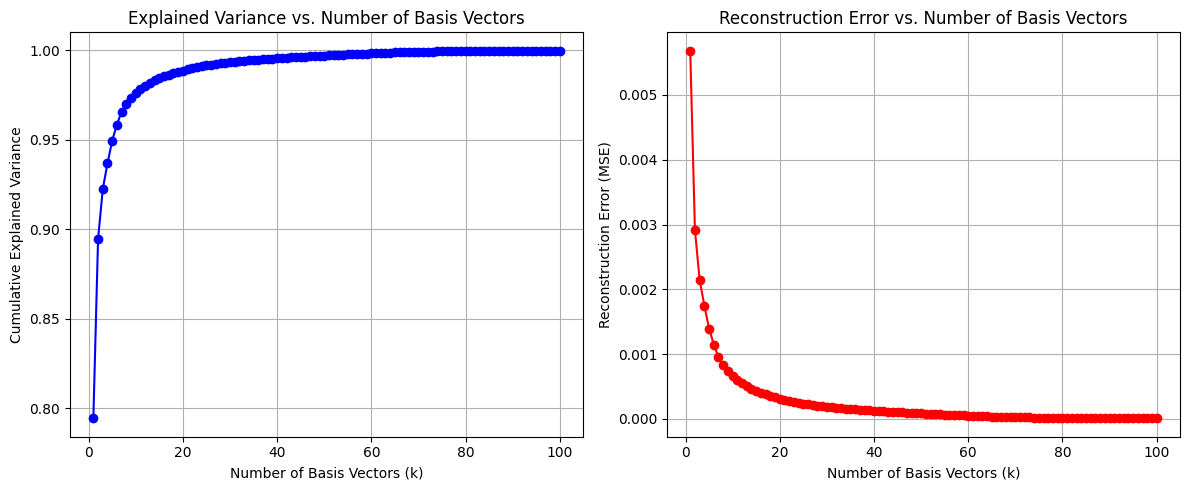

前10个奇异值: [343.57816103 122.0109094   64.37566516  46.08531018  43.63772404
  36.4409968   32.61344334  25.5960681   22.08319761  20.7921175 ]
前5个基向量形状: (5, 400)
使用10个基向量解释的方差: 97.63%
使用20个基向量解释的方差: 98.87%


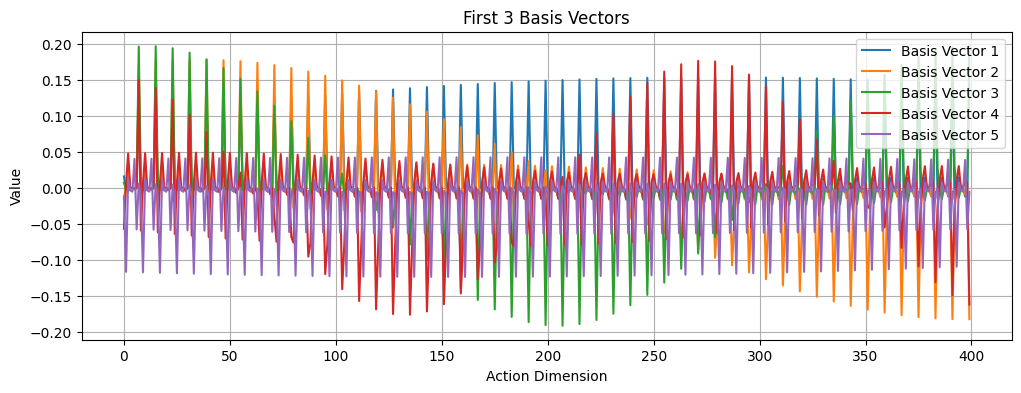

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# 1. 准备动作数据
actions = np.array([frame['target'] for frame in full_dataset.sequences])  # (n_samples, action_dim)
print(f"原始动作数据形状: {actions.shape}")

# 2. 数据标准化 (减去均值)
mean_actions = np.mean(actions, axis=0)
actions_centered = actions - mean_actions

# 3. 执行SVD分解
U, s, Vh = np.linalg.svd(actions_centered, full_matrices=False)

# 4. 计算累积解释方差
total_variance = np.sum(s**2)
explained_variance = (s**2) / total_variance
cumulative_variance = np.cumsum(explained_variance)

# 5. 计算不同k值的重构误差
max_k = min(100, actions.shape[1])  # 最多取50个基向量
k_values = range(1, max_k + 1)
reconstruction_errors = []

for k in k_values:
    # 使用前k个基向量重构
    reconstructed = U[:, :k] @ np.diag(s[:k]) @ Vh[:k, :]
    # 计算重构误差 (MSE)
    error = np.mean((actions_centered - reconstructed) ** 2)
    reconstruction_errors.append(error)

# 6. 可视化结果
plt.figure(figsize=(12, 5))

# 子图1: 解释方差
plt.subplot(1, 2, 1)
plt.plot(k_values, cumulative_variance[:max_k], 'b-o')
plt.xlabel('Number of Basis Vectors (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Basis Vectors')
plt.grid(True)

# 子图2: 重构误差
plt.subplot(1, 2, 2)
plt.plot(k_values, reconstruction_errors, 'r-o')
plt.xlabel('Number of Basis Vectors (k)')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Basis Vectors')
plt.grid(True)

plt.tight_layout()
plt.show()

# 7. 打印关键信息
print(f"前10个奇异值: {s[:10]}")
print(f"前5个基向量形状: {Vh[:5, :].shape}")
print(f"使用10个基向量解释的方差: {cumulative_variance[9]:.2%}")
print(f"使用20个基向量解释的方差: {cumulative_variance[19]:.2%}")

# 8. 可视化前几个基向量
plt.figure(figsize=(12, 4))
for i in range(5):  # 显示前3个基向量
    plt.plot(Vh[i, :], label=f'Basis Vector {i+1}')
plt.xlabel('Action Dimension')
plt.ylabel('Value')
plt.title('First 3 Basis Vectors')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
reconstruction_errors[50]

7.859416705070149e-05